In [1]:
import findspark, sys

# Locate the Spark installation (add pyspark to sys.path, see https://github.com/minrk/findspark#readme)
findspark.init()
print(f'Using Spark located in {findspark.find()}.')

from pyspark.sql import SparkSession

# Create or get the Spark session (singleton) and the underlying Spark context
spark = SparkSession.builder.getOrCreate()

Using Spark located in /usr/local/spark/.


In [97]:
import pyspark as ps, nltk, pymongo, pandas as pd, re, sklearn, operator, numpy as np, seaborn as sb
from pyspark.sql.functions import udf, col, size
from pyspark.sql.types import BooleanType, DoubleType, LongType, StringType, StructField, StructType, IntegerType, ArrayType

from pyspark.ml.feature import Tokenizer, CountVectorizer, StopWordsRemover, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, LinearSVC
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics

# Fifth Hypothesis:

In the following notebook the following hypothesis, already analyzed in local (using standard python), will be replicated on the Big Data source located in the HDFS:
 - **Does there exist a relationship between the text of the review and the number of *votes up* that it receives? Can we predict this value with a Machine Learning model?**

## Correlation between the text of the review and the votes up

We want to start with an easy model that just considers the text of the review and the votes up, in order to understand if there is a correlation between those two features. <br>
If the overall accuracy of that simple model is good enough we'll stop considering it as the optimal one, otherwise we'll add new reasonable features to the model in order to increase the obtained performances.

### Import reviews data from HDFS & select relevant features to perform the analysis

In [3]:
# Define the schema for the base reviews dataset
base_reviews_schema = StructType([
    #StructField('base_review_id', LongType(), True),
    StructField('steamid', LongType(), True),
    StructField('appid', LongType(), True),
    StructField('voted_up', BooleanType(), True),
    StructField('votes_up', LongType(), True),
    StructField('votes_funny', LongType(), True),
    StructField('weighted_vote_score', DoubleType(), True),
    StructField('playtime_forever', LongType(), True),
    StructField('playtime_at_review', LongType(), True),
    StructField('num_games_owned', LongType(), True),
    StructField('num_reviews', LongType(), True),
    StructField('review', StringType(), True),
    StructField('unix_timestamp_created', LongType(), True),
    StructField('unix_timestamp_updated', LongType(), True)
])

# Read the base reviews dataset from HDFS
base_reviews_df = spark.read.csv(
    path='hdfs://localhost:54310/final_project/data/base_reviews',
    schema=base_reviews_schema,
    escape='"',
    header=True,
    ignoreTrailingWhiteSpace=True,
    mode='FAILFAST',
    multiLine=True,
    unescapedQuoteHandling='STOP_AT_CLOSING_QUOTE'
).to_pandas_on_spark()

In [4]:
df = base_reviews_df
df[['review', 'votes_up']].to_spark().limit(5).toPandas()

,review,votes_up
0,best gameplay ever created,0
1,Timeless. Thank you volvo.,0
2,this game literally made me love guns and fps ...,0
3,If this gets a rework in 2021 it's going to be...,0
4,ok,0


### Remove empty text reviews

We saw in the local analysis that some reviews have an associated empty text, even in this case we'll remove those reviews.

In [5]:
tot_len = df.size
# Remove NaN elements in dataframe
df = df.dropna(subset="review")
print(f"Removed reviews: {tot_len - df.size}")

Removed reviews: 24271


### Divide reviews in two classes: useful & not useful

Since this hypothesis can be used by Steam in order to display, for users that are interested on buying a new game, only the potential useful reviews (the ones having more than N votes up) the idea is to consider only useful and not useful reviews and build a model that is capable of recognizing those two classes. <br>
Since we do not want our model to be biased towards one of the two classes, we'll consider the same number of samples for the two different classes (useful/not useful review).<br>
For us a good review is when its associated *votes_up* has a value greater than the M percentile of the overall *votes_up* distribution.

In [6]:
votes_up_for_useful_review = df.votes_up.quantile([.99])[0]
votes_up_for_useful_review

8.0

In [7]:
ps.pandas.set_option('compute.ops_on_diff_frames', True)
useful_reviews_df = df[df['votes_up'] >= votes_up_for_useful_review]
not_useful_reviews_df = df[df['votes_up'] < votes_up_for_useful_review].sample(frac=(useful_reviews_df.size/df.size), random_state=0)
ps.pandas.reset_option('compute.ops_on_diff_frames')
# NOTE: Unfortunately the len of the two dataframes is not equal
restricted_df = ps.pandas.concat([useful_reviews_df, not_useful_reviews_df])

In [8]:
# Replace the output label with a 1 (so a good review) if the review's votes up are greater than threshold, 0 otherwise
udf_y = udf(lambda x: 0 if x < votes_up_for_useful_review else 1, IntegerType())

restricted_df = restricted_df.to_spark().withColumn('useful', udf_y(col('votes_up'))).to_pandas_on_spark()
restricted_df[['review', 'votes_up', 'useful']].to_spark().limit(5).toPandas()

,review,votes_up,useful
0,⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣀⣀⣀⣠⣤⣤⣄⣀⣀⣀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀\n⠀⠀⠀⠀...,16,1
1,GAME OF MY CHILDHOOD\nRECCOMEND IT \nLEGENT NE...,11,1
2,"Legendary game, watched my uncle play it a lot...",34,1
3,One of the best games ever made and still aliv...,13,1
4,Were we all started..,26,1


### Obtain the Bag-Of-Words and predict, using the review text, the votes_up categorical values

#### Obtaining BoW

In [9]:
# pyspark.ml works only with SQL Pyspark dataframes
restricted_df = restricted_df.to_spark()

In [10]:
# Remove not characters (and \n) in written reviews and transform the text into lowercase
def clean(input):
    return ''.join(list(filter(lambda ele: re.search("[a-zA-Z\s]+", ele) is not None, list(re.sub('\n', ' ', input.lower())))))

udf_remove_not_characters = udf(lambda x: clean(x), StringType())
clean_df = restricted_df.withColumn('cleaned_review', udf_remove_not_characters(col('review')))

In [11]:
# Tokenization - break review text into list of its individual terms (words in this case)
tokenizer = Tokenizer(inputCol='cleaned_review', outputCol='review_words')
wordsData = tokenizer.transform(clean_df)

# Remove review having no words after filtering
wordsData = wordsData.filter(size(col('review_words')) > 0)

In [12]:
# Removing StopWords
remover = StopWordsRemover(inputCol='review_words', outputCol='no_stop_words')
filteredData = remover.transform(wordsData)

In [13]:
# Apply stemmatization
stemmer = nltk.stem.SnowballStemmer('english')
udf_stemming = udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))
stemmed_df = filteredData.withColumn('stemmed_review', udf_stemming(col('no_stop_words')))

In [14]:
# Apply CountVectorizer - it converts the list of tokens to vector of token counts
count = CountVectorizer(inputCol='no_stop_words', outputCol='BoW')
model = count.fit(stemmed_df)
featurizedData = model.transform(stemmed_df)
featurizedData[['review', 'cleaned_review', 'review_words', 'no_stop_words', 'stemmed_review', 'BoW', 'votes_up', 'useful']].limit(5).toPandas()

,review,cleaned_review,review_words,no_stop_words,stemmed_review,BoW,votes_up,useful
0,GAME OF MY CHILDHOOD\nRECCOMEND IT \nLEGENT NE...,game of my childhood reccomend it legent neve...,"[game, of, my, childhood, reccomend, it, , leg...","[game, childhood, reccomend, , legent, never, ...","[game, childhood, reccomend, , legent, never, ...","(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",11,1
1,"Legendary game, watched my uncle play it a lot...",legendary game watched my uncle play it a lot ...,"[legendary, game, watched, my, uncle, play, it...","[legendary, game, watched, uncle, play, lot, i...","[legendari, game, watch, uncl, play, lot, inhe...","(0.0, 2.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, ...",34,1
2,One of the best games ever made and still aliv...,one of the best games ever made and still aliv...,"[one, of, the, best, games, ever, made, and, s...","[one, best, games, ever, made, still, alive, t...","[one, best, game, ever, made, still, aliv, today]","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...",13,1
3,Were we all started..,were we all started,"[were, we, all, started]",[started],[start],"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",26,1
4,"I wish I grew up playing this, not global offe...",i wish i grew up playing this not global offen...,"[i, wish, i, grew, up, playing, this, not, glo...","[wish, grew, playing, global, offensive]","[wish, grew, play, global, offens]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",12,1


#### Make prediction using Logistic Regression (BoW)

We'll start using an easier model and see the effects of using BoW on the overall performances. <br>
In order to obtain a proper value for the regularization term of the Logistic Regression model a *grid search* approach has been used.

In [15]:
# Split the dataframe in two - train & test
projected_df = featurizedData[['BoW', 'useful']]
trainDF, testDF = projected_df.randomSplit([0.9, 0.1], 0)
projected_df.limit(5).toPandas()

,BoW,useful
0,"(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
1,"(0.0, 2.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, ...",1
2,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...",1
3,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
4,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1


In [16]:
# Create an instance of LogisticRegression classifier
lr = LogisticRegression(featuresCol='BoW', labelCol='useful', regParam=30)

# Fit the model
lr_model = lr.fit(trainDF)

# Show accuracy
print(f"Train Logistic Regression accuracy: {(lr_model.evaluate(trainDF).accuracy) * 100:.2f}")
print(f"Test Logistic Regression accuracy: {(lr_model.evaluate(testDF).accuracy) * 100:.2f}")

Train Logistic Regression accuracy: 67.40
Test Logistic Regression accuracy: 64.29


Those results show (no matter the model) that there is a correlation between the text of the review and the *votes_up* label, otherwise the accuracy of our model would have been of the 50% (randomly picking one class). <br>

## Add new features to the simple model (that just uses reviews' text), to improve predictions 

Can we increase the accuracy of our model by adding new suited features to the model's input?

### Gather useful data about games and join them on 'appid' with reviews

The review data are already stored, so we need to load the data about the games.

In [17]:
# Connect to the mongo local and load as a dataframe the games collection
mongo = pymongo.MongoClient()
mongo_db = mongo.final_project
games_df = pd.DataFrame(list(mongo_db.games.find({}, {'_id': False})))[['appid', 'genres', 'owners']]
mongo.close() #Close the connections

games_df

,appid,genres,owners
0,20,Action,5000000-10000000
1,30,Action,5000000-10000000
2,10,Action,10000000-20000000
3,50,Action,5000000-10000000
4,60,Action,5000000-10000000
...,...,...,...
27070,1065160,Indie,0-20000
27071,1065570,Action;Adventure;Indie,0-20000
27072,1066700,Adventure;Casual;Indie,0-20000
27073,1069460,Adventure;Casual;Indie,0-20000


#### Better handling of game columns

##### 1. Genres

Since a game can have at least one genre we'll store for each game a dict that has value equal to 1 if the genre applies to the game (0 otherwise).

In [18]:
games_df['genres'] = games_df.genres.str.split(';')
# get all unique genres
all_genres = games_df.genres.apply(pd.Series).stack().reset_index(drop=True).unique()
# a dict for each game, each dict has all of the genres, val=1 if genre applies to game
gen_dicts = games_df.genres.apply(lambda gens : { **{g:0 for g in all_genres}, **{ g:1 for g in gens } } )
# delete now useless column
del games_df['genres']
# merge with original
games_df = pd.concat([games_df.reset_index(drop=True), gen_dicts.apply(pd.Series).reset_index(drop=True)] , axis=1)

In [19]:
games_df

,appid,owners,Action,Free to Play,Strategy,Adventure,Indie,RPG,Animation & Modeling,Video Production,...,Web Publishing,Education,Software Training,Sexual Content,Audio Production,Game Development,Photo Editing,Accounting,Documentary,Tutorial
0,20,5000000-10000000,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,30,5000000-10000000,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10,10000000-20000000,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,50,5000000-10000000,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,60,5000000-10000000,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,1065160,0-20000,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27071,1065570,0-20000,1,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27072,1066700,0-20000,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27073,1069460,0-20000,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### 2. Owners

Since we know for each game a range of the minimum and maximum number of owners, for each game we will consider the number of owners as a mean of those two values.

In [20]:
games_owners_range = list(games_df.owners.str.split('-'))
# Obtain the minimum and maximum values of owners for each videogame and cast those single values to Int
list_min_games_owners = list(map(int, map(operator.itemgetter(0), games_owners_range)))
list_max_games_owners = list(map(int, map(operator.itemgetter(-1), games_owners_range))) 
# For each game perform the mean value of owners
games_df['owners'] = list(map(int, np.divide(list(map(operator.add, list_min_games_owners, list_max_games_owners)), 2)))
games_df['owners']

0         7500000
1         7500000
2        15000000
3         7500000
4         7500000
           ...   
27070       10000
27071       10000
27072       10000
27073       10000
27074       10000
Name: owners, Length: 27075, dtype: int64

In [21]:
# Normalize game owners
games_owners = np.array(games_df['owners'])[:, np.newaxis]
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(games_owners)
games_df['owners_norm'] = scaler.transform(games_owners)

#### Join

In [22]:
# Join the subset of reviews and the games dataset 
games_df = spark.createDataFrame(games_df).to_pandas_on_spark()
join_df = featurizedData.to_pandas_on_spark().merge(games_df, on='appid', how="left")
join_df.to_spark().limit(5).toPandas()

,steamid,appid,voted_up,votes_up,votes_funny,weighted_vote_score,playtime_forever,playtime_at_review,num_games_owned,num_reviews,...,Education,Software Training,Sexual Content,Audio Production,Game Development,Photo Editing,Accounting,Documentary,Tutorial,owners_norm
0,76561198989429229,10,True,11,6,0.629035,348,348,4,4,...,0,0,0,0,0,0,0,0,0,11.193669
1,76561198053333797,10,True,34,2,0.772390,111772,111760,28,2,...,0,0,0,0,0,0,0,0,0,11.193669
2,76561198009260426,10,True,13,1,0.645567,5893,5819,278,36,...,0,0,0,0,0,0,0,0,0,11.193669
3,76561198149805308,10,True,26,2,0.721466,124,124,26,7,...,0,0,0,0,0,0,0,0,0,11.193669
4,76561198358607702,10,True,12,1,0.659487,10975,1097,526,227,...,0,0,0,0,0,0,0,0,0,11.193669


### Add videogame owners (normalized), to the simple model (BoW)

If the game is owned by lot of players maybe more user (e.g., that are interested on buying a community liked videogame) are reading the reviews and so more votes_up the review gets.<br>
Applying a normalization to the videogame owners number is necessary since the range of values that this feature can have is larger with respect to the BoW (they can have more weight in the model and so the prediction results become unexpected). <br> A *Mean-Var Normalization* technique has been chosen.

In [23]:
# Since Pyspark ml wants a column as feature input we have to append to the BoW array also the game owners normalized
vecAssembler = VectorAssembler(inputCols=['BoW', 'owners_norm'], outputCol='features')
assembledData = vecAssembler.transform(join_df.to_spark())

# Split the dataframe in two - train & test
projected_df = assembledData[['features', 'useful']]
trainDF, testDF = projected_df.randomSplit([0.9, 0.1], 0)

#### Make prediction using Logistic Regression (BoW + owners)

In [24]:
# Create an instance of LogisticRegression classifier
lr = LogisticRegression(labelCol='useful', regParam=30)

# Fit the model
lr_model = lr.fit(trainDF)

# Show accuracy
print(f"Train Logistic Regression accuracy: {(lr_model.evaluate(trainDF).accuracy) * 100:.2f}")
print(f"Test Logistic Regression accuracy: {(lr_model.evaluate(testDF).accuracy) * 100:.2f}")

Train Logistic Regression accuracy: 67.94
Test Logistic Regression accuracy: 64.94


It can be noticed that a slightly improvement is added if considering also the number of players that own that particular game. <br>
This suggest to add this feature to our model.

### Add videogame genre/s, to the simple model (BoW)

From **hp3** we have obtained that some genres are more appreciated with respect to others, so maybe also the associated votes_up for a review is different if the review is referred to a game of a/some genre/s.

In [25]:
# Bow + genres
cols = (list(join_df.columns[-32:-1]))
del cols[-30]

# Since Pyspark ml wants a column as feature input we have to append to the BoW array also the genres
vecAssembler = VectorAssembler(inputCols=cols, outputCol='features')
assembledData = vecAssembler.transform(join_df.to_spark())

# Split the dataframe in two - train & test
projected_df = assembledData[['features', 'useful']]
trainDF, testDF = projected_df.randomSplit([0.9, 0.1], 0)

#### Make prediction using Logistic Regression (BoW + genre/s)

In [26]:
# Create an instance of LogisticRegression classifier
lr = LogisticRegression(labelCol='useful', regParam=30)

# Fit the model
lr_model = lr.fit(trainDF)

# Show accuracy
print(f"Train Logistic Regression accuracy: {(lr_model.evaluate(trainDF).accuracy) * 100:.2f}")
print(f"Test Logistic Regression accuracy: {(lr_model.evaluate(testDF).accuracy) * 100:.2f}")

Train Logistic Regression accuracy: 68.16
Test Logistic Regression accuracy: 65.24


This result shows that adding the genre/s to the model produces overfitting (the training accuracy increases whereas the test decreases).

### Add how are liked the review written by a specific user, to the simple model (BoW)

The metric we are performing interested studying is:
 - **user_reviews_appreciation = sum_reviews_votes_up / num_reviews**

In [27]:
ps.pandas.set_option('compute.ops_on_diff_frames', True)
user_reviews_appreciation = join_df.groupby('steamid')['votes_up'].sum() / join_df.groupby('steamid').size()
ps.pandas.reset_option('compute.ops_on_diff_frames')
user_reviews_appreciation.name = 'user_reviews_appreciation'
user_reviews_appreciation

steamid
76561197960265858      14.000000
76561197960267483      12.000000
76561197960268122      97.000000
76561197960269475     158.000000
76561197960271994      16.000000
76561197960273916       0.000000
76561197960273963      12.000000
76561197960275208       9.000000
76561197960276316      21.000000
76561197960283697       0.000000
76561197960289242       0.000000
76561197960290429       0.000000
76561197960293042       9.000000
76561197960302047      17.000000
76561197960304942      12.000000
76561197960308548       0.000000
76561197960311493    1044.000000
76561197960315996      51.000000
76561197960319772       9.000000
76561197960320732      29.000000
76561197960320897      15.000000
76561197960329198       0.000000
76561197960330605      19.000000
76561197960336213      24.000000
76561197960337918      33.000000
76561197960339341      11.000000
76561197960339937       1.000000
76561197960342394       9.000000
76561197960342473      28.000000
76561197960343952      19.000000
76

In [28]:
join_df = join_df.merge(user_reviews_appreciation.reset_index(), on='steamid', how='left')
join_df.to_spark().limit(5).toPandas()

,steamid,appid,voted_up,votes_up,votes_funny,weighted_vote_score,playtime_forever,playtime_at_review,num_games_owned,num_reviews,...,Software Training,Sexual Content,Audio Production,Game Development,Photo Editing,Accounting,Documentary,Tutorial,owners_norm,user_reviews_appreciation
0,76561198989429229,10,True,11,6,0.629035,348,348,4,4,...,0,0,0,0,0,0,0,0,11.193669,11.0
1,76561198009260426,10,True,13,1,0.645567,5893,5819,278,36,...,0,0,0,0,0,0,0,0,11.193669,13.0
2,76561198053333797,10,True,34,2,0.772390,111772,111760,28,2,...,0,0,0,0,0,0,0,0,11.193669,34.0
3,76561198149805308,10,True,26,2,0.721466,124,124,26,7,...,0,0,0,0,0,0,0,0,11.193669,26.0
4,76561198358607702,10,True,12,1,0.659487,10975,1097,526,227,...,0,0,0,0,0,0,0,0,11.193669,12.0


In [29]:
# Transform user_review_appreciation column as StandardScaler likes
vecAssembler1 = VectorAssembler(inputCols=['user_reviews_appreciation'], outputCol='assembled_user_reviews_appreciation')
assembledData = vecAssembler1.transform(join_df.to_spark())

# Normalize user reviews appreciation
standardScaler = StandardScaler(inputCol='assembled_user_reviews_appreciation', outputCol='user_reviews_appreciation_norm')
standardizedData = standardScaler.fit(assembledData).transform(assembledData)

# Since Pyspark ml wants a column as feature input we have to append to the BoW array also the user_reviews_appreciation normalized
vecAssembler = VectorAssembler(inputCols=['BoW', 'user_reviews_appreciation_norm'], outputCol='features')
assembledData = vecAssembler.transform(standardizedData)

# Split the dataframe in two - train & test
projected_df = assembledData[['features', 'useful']]
trainDF, testDF = projected_df.randomSplit([0.9, 0.1], 0)

#### Logistic Regression (BoW + user_reviews_appreciation)

In [41]:
# Create an instance of LogisticRegression classifier
lr = LogisticRegression(labelCol='useful', regParam=30)

# Fit the model
lr_model = lr.fit(trainDF)

# Show accuracy
print(f"Train Logistic Regression accuracy: {(lr_model.evaluate(trainDF).accuracy) * 100:.2f}")
print(f"Test Logistic Regression accuracy: {(lr_model.evaluate(testDF).accuracy) * 100:.2f}")

Train Logistic Regression accuracy: 68.00
Test Logistic Regression accuracy: 65.07


This feature improves a lot the overall accuracy, so it can be considered as a good one.

### Best model (using all the more relevant features)

Since we noticed that adding some features increases more with respect to other the overall accuracy is better to add only the more relevant features (the ones that are changing most the accuracy).

In [54]:
# Since Pyspark ml wants a column as feature input we have to append to the BoW array also the user_reviews_appreciation normalized
vecAssembler = VectorAssembler(inputCols=['BoW', 'owners_norm', 'user_reviews_appreciation_norm'], outputCol='features')
assembledData = vecAssembler.transform(standardizedData)

# Split the dataframe in two - train & test
projected_df = assembledData[['features', 'useful']]
trainDF, testDF = projected_df.randomSplit([0.9, 0.1], 0)

##### Logistic Regression (BoW + owners + user_reviews_appreciation)

In [32]:
# Create an instance of LogisticRegression classifier
lr = LogisticRegression(labelCol='useful', regParam=30)

# Fit the model
lr_model = lr.fit(trainDF)

# Show accuracy
print(f"Train Logistic Regression accuracy: {(lr_model.evaluate(trainDF).accuracy) * 100:.2f}")
print(f"Test Logistic Regression accuracy: {(lr_model.evaluate(testDF).accuracy) * 100:.2f}")

Train Logistic Regression accuracy: 68.00
Test Logistic Regression accuracy: 65.07


The overall accuracy can be considered not as optimal, but good enough (for sure better than the simpler model, the one that only uses BoW).<br>
Remember that we use not a huge number of features, and the training using simple models (like Logistic Regression) takes fewer time. <br><br>
During this discussion we only used the Logistic Regression, but what happens if we use instead different models such as SVM (using the more relevant features)?

##### Linear Support Vector Machine (BoW + owners + user_review_appreciation)

Unfortunately Pyspark does not implement SVM using not linear kernels, so we opted for the linear version hoping it will work better with respect to Logistic regression.
In order to obtain a proper value for the regularization term of the SVM model a *grid search* approach has been used.

In [38]:
# Create an instance of linear SVM classifier
l_svm = LinearSVC(labelCol='useful', regParam=10)

# Fit the model
l_svm_model = l_svm.fit(trainDF)

# Show accuracy
print(f"Train Logistic Regression accuracy: {(l_svm_model.evaluate(trainDF).accuracy) * 100:.2f}")
print(f"Test Logistic Regression accuracy: {(l_svm_model.evaluate(testDF).accuracy) * 100:.2f}")

Train Logistic Regression accuracy: 61.61
Test Logistic Regression accuracy: 58.24


### Model evaluation - using the "best model"

Is our "best model" more biased towards recognizing one of the two classes?

In [48]:
lr_acc = lr_model.evaluate(testDF).accuracy
l_svm_acc = l_svm_model.evaluate(testDF).accuracy
best_model = l_svm_model if l_svm_acc > lr_acc else lr_model

#### Confusion Matrix

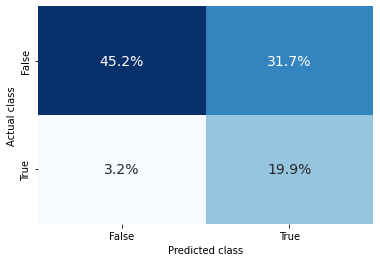

In [114]:
predictions = best_model.transform(testDF)
predictions = (predictions.withColumn('label', predictions['useful'].cast('double')))
metrics = MulticlassMetrics(predictions.select(['label', 'prediction']).rdd)

cf_matrix = metrics.confusionMatrix().toArray()
sb.heatmap(cf_matrix/np.sum(cf_matrix),
           annot=True,
           fmt='.1%',
           cmap='Blues',
           cbar=False,
           xticklabels=['False', 'True'], yticklabels=['False', 'True'],
           annot_kws={
                'fontsize': 14
            }).set(xlabel='Predicted class', ylabel='Actual class');

#### Precision & Recall

In [115]:
precision = metrics.precision(1.0)
recall = metrics.recall(1.0)
f1 = metrics.fMeasure(1.0)
print('Best model:', 'SVM' if l_svm_acc > lr_acc else 'Logistic Regression', '\n\nPrecision: ', round(precision, 2), '\nRecall: ', round(recall, 2), '\nF1:', round(f1, 2))
area_under_PR = BinaryClassificationMetrics(predictions.select(['label', 'prediction']).rdd).areaUnderPR
print('Area under Precision-Recall curve: ', round(area_under_PR , 2))

Best model: Logistic Regression 

Precision:  0.39 
Recall:  0.86 
F1: 0.53
Area under Precision-Recall curve:  0.37
